In [1]:
import numpyro
numpyro.enable_x64()
numpyro.set_platform("cpu")
numpyro.set_host_device_count(10)

import arviz as az
import numpy as np
import pandas as pd
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import random, jit, lax
from corner import corner
from numpyro import handlers
from numpyro.infer import MCMC, NUTS, init_to_median, init_to_value, Predictive, SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoDelta
from numpyro.optim import Adam
from eggman.infer import Star

rng = random.PRNGKey(42)

Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.
I0000 00:00:1696259647.392124    7672 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [2]:
dist = numpyro.distributions

In [3]:
class TrueStar(Star):
    max_distance = 500.  # parsecs
    max_av = 1.
    
    def prior(self, const):
        x = numpyro.sample("x", dist.Uniform(0.0, 0.999))
        ln_mass = numpyro.sample("ln_mass", dist.TruncatedNormal(-0.2, 0.7, low=jnp.log(0.7), high=jnp.log(2.3)))
        y = numpyro.sample("Y", dist.Uniform(0.22, 0.32))
        mh = numpyro.sample("M_H", dist.TruncatedNormal(0.0, 0.5, low=-0.9, high=0.5))
        a_mlt = numpyro.deterministic("a_MLT", 2.0)
        
        # This is the inverse of a Beta distribution where beta = 1
        # In particular, alpha = 3 is the inverse of a distance^2 distribution
        plx = numpyro.sample("plx", dist.Pareto(1/self.max_distance, 3.0))
        
        # This is just p(av) ~ av^(alpha - 1)
        av_scaled = numpyro.sample("Av_scaled", dist.Beta(2., 1.))
        av = numpyro.deterministic("Av", self.max_av * av_scaled)
        return x, ln_mass, y, mh, a_mlt, plx, av

In [4]:
num_stars = 100

true_model = TrueStar()
# true_model._x_bounds = jnp.array([0.0, 0.25, 0.5, 0.75, 1.0])
# true_model._eep_funclist = true_model._get_eep_funclist()

rng, key = random.split(rng)
pred = Predictive(true_model, num_samples=num_stars)
const = {}
truths = pred(key, const)

In [5]:
# pd.DataFrame(truths).to_csv("truths.csv")

In [6]:
# df = pd.read_csv("truths.csv").drop(columns="Unnamed: 0")
# truths = {key: df[key].to_numpy(np.float32) for key in df.columns}
# truths

Beta dist with beta = 1 is just a bounded power law dist where the power is (alpha - 1)

In [7]:
from numpyro.distributions.util import clamp_probs

class TwoSidedTruncatedDistribution(dist.TwoSidedTruncatedDistribution):
    def icdf(self, u):
        loc = self.base_dist.loc
        sign = jnp.where(loc >= self.low, 1.0, -1.0)
        return (1 - sign) * loc + sign * self.base_dist.icdf(
            clamp_probs((1 - u) * self._tail_prob_at_low + u * self._tail_prob_at_high)
        )

def TruncatedNormal(loc=0.0, scale=1.0, *, low=None, high=None, validate_args=None):
    return TwoSidedTruncatedDistribution(
        dist.Normal(loc, scale), low=low, high=high, validate_args=validate_args
    )

In [8]:
from eggman.infer.models import lognorm_from_norm

class NewStar(Star):
    def prior(self, const):
        x = numpyro.sample("x", dist.Uniform(0.0, 0.999))
#         x = numpyro.sample("x", TruncatedNormal(0.5, 2.0, low=0.0, high=1.0))
        # ln_mass = numpyro.sample("ln_mass", LogSalpeter(jnp.log(0.7), jnp.log(2.3), rate=2.35))
        # Good approximation of Chabrier IMF
        ln_mass = numpyro.sample("ln_mass", TruncatedNormal(-0.2, 0.7, low=jnp.log(0.7), high=jnp.log(2.3)))
        y = numpyro.sample("Y", dist.Uniform(0.22, 0.32))
#         y = numpyro.sample("Y", TruncatedNormal(0.26, 0.1, low=0.22, high=0.32))
        
        mh = numpyro.sample("M_H", TruncatedNormal(const["M_H"]["mu"], const["M_H"]["sigma"], low=-0.9, high=0.5))
        
        a_mlt = numpyro.sample("a_MLT", dist.Uniform(1.3, 2.7))
#         a_mlt = numpyro.sample("a_MLT", TruncatedNormal(2.0, 2.0, low=1.3, high=2.7))
        
        plx_dist = dist.LogNormal(*lognorm_from_norm(const["plx"]["mu"], const["plx"]["sigma"]))
        plx = numpyro.sample("plx", plx_dist)

        av_dist = dist.LogNormal(*lognorm_from_norm(const["Av"]["mu"], const["Av"]["sigma"]))            
        av = numpyro.sample("Av", av_dist)

        return x, ln_mass, y, mh, a_mlt, plx, av

In [9]:
model = NewStar()
model.dof = 10

for band in model.bands:
    const[band] = dict(sigma=3e-3)

In [13]:
i = 15

const["M_H"] = dict(mu=truths["M_H"][i], sigma=0.1)
const["plx"] = dict(mu=truths["plx"][i], sigma=4e-5)
const["Av"] = dict(mu=truths["Av"][i], sigma=0.01*truths["Av"][i])
obs = {key: truths[key][i] for key in model.bands}

In [14]:
guide = AutoDelta(model)
optim = Adam(step_size=0.001)
loss = Trace_ELBO()
svi = SVI(model, guide, optim, loss)

In [21]:
num_steps = 1000
rng, key = random.split(rng)
svi_result = svi.run(key, num_steps, const, obs=obs)

100%|█████████████████████████| 1000/1000 [00:01<00:00, 558.59it/s, init loss: 127.7629, avg. loss [951-1000]: -36.4895]


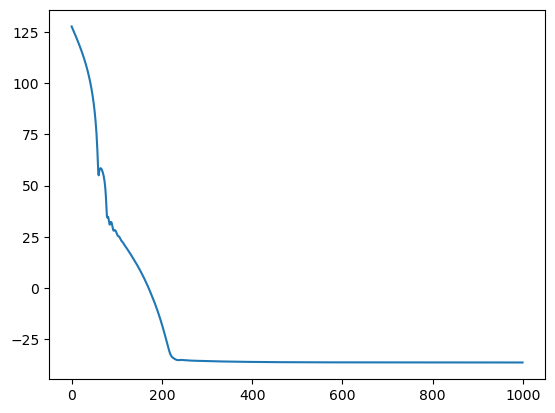

In [22]:
plt.plot(svi_result.losses)

In [23]:
values = guide.sample_posterior(key, svi_result.params, const, obs=obs)

In [25]:
sampler = NUTS(model, init_strategy=init_to_value(values=values))
mcmc = MCMC(sampler, num_warmup=1000, num_samples=1000, num_chains=10)

In [26]:
rng, key = random.split(rng)

extra_fields = ("adapt_state.step_size", "accept_prob", "num_steps")
mcmc.warmup(key, const, extra_fields=extra_fields, collect_warmup=True, obs=obs)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [27]:
fields = mcmc.get_extra_fields(group_by_chain=True)
step_size = fields["adapt_state.step_size"]
accept_prob = fields["accept_prob"]
num_steps = fields["num_steps"]
tree_depth = np.log2(num_steps).astype(int) + 1.

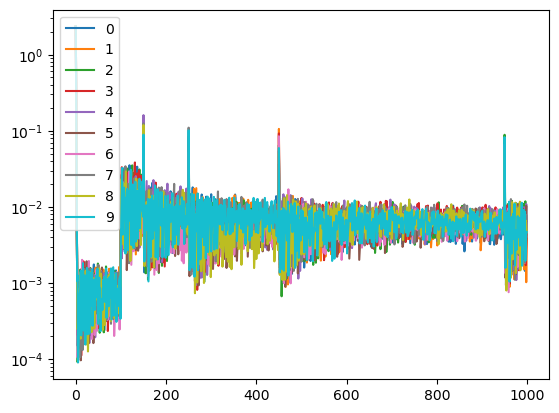

In [28]:
fig, ax = plt.subplots()
ax.plot(step_size.T, label=list(range(10)))
ax.set_yscale("log")
ax.legend();

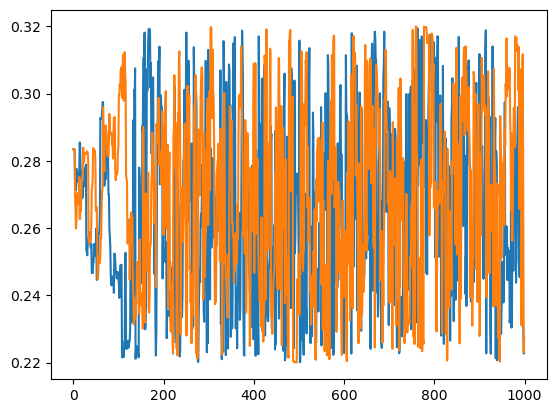

In [29]:
plt.plot(mcmc.get_samples(True)["Y"][6:8].T);

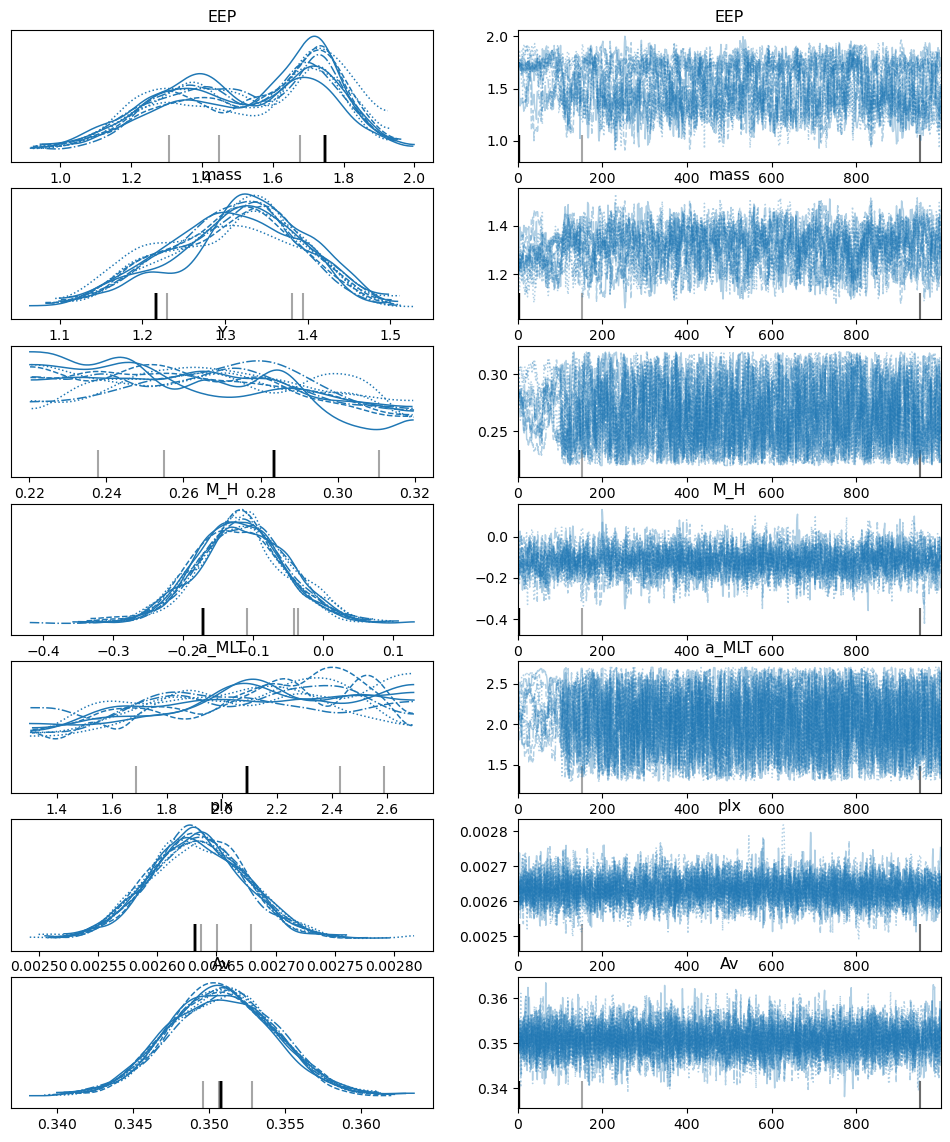

In [30]:
var_names = [
    "EEP", 
    "mass", 
    "Y", 
    "M_H", 
    "a_MLT", 
    "plx",
    "Av",
]
az.plot_trace(az.from_numpyro(mcmc), var_names=var_names);

In [31]:
rng, key = random.split(rng)
mcmc.run(key, const, extra_fields=extra_fields, obs=obs)
mcmc.print_summary()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        Av      0.35      0.00      0.35      0.35      0.36   7182.76      1.00
       M_H     -0.12      0.06     -0.12     -0.22     -0.01   3675.94      1.00
         Y      0.26      0.03      0.26      0.22      0.31   3099.84      1.00
     a_MLT      2.03      0.39      2.04      1.48      2.70   4913.22      1.00
   ln_mass      0.27      0.06      0.28      0.16      0.37   1547.89      1.01
       plx      0.00      0.00      0.00      0.00      0.00   6304.39      1.00
         x      0.46      0.07      0.46      0.35      0.55   1340.23      1.01

Number of divergences: 0


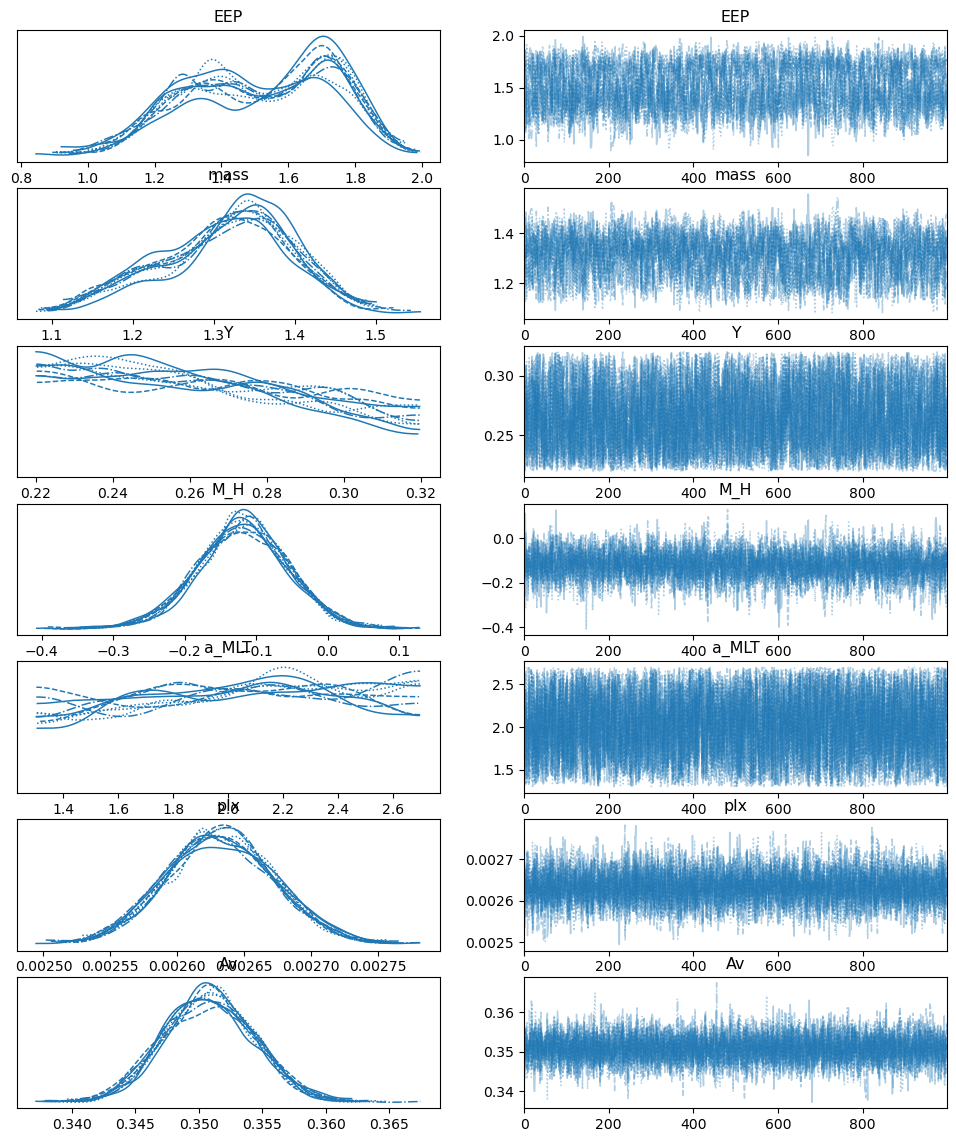

In [32]:
az.plot_trace(az.from_numpyro(mcmc), var_names=var_names);

In [33]:
data = az.from_numpyro(mcmc)
data

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

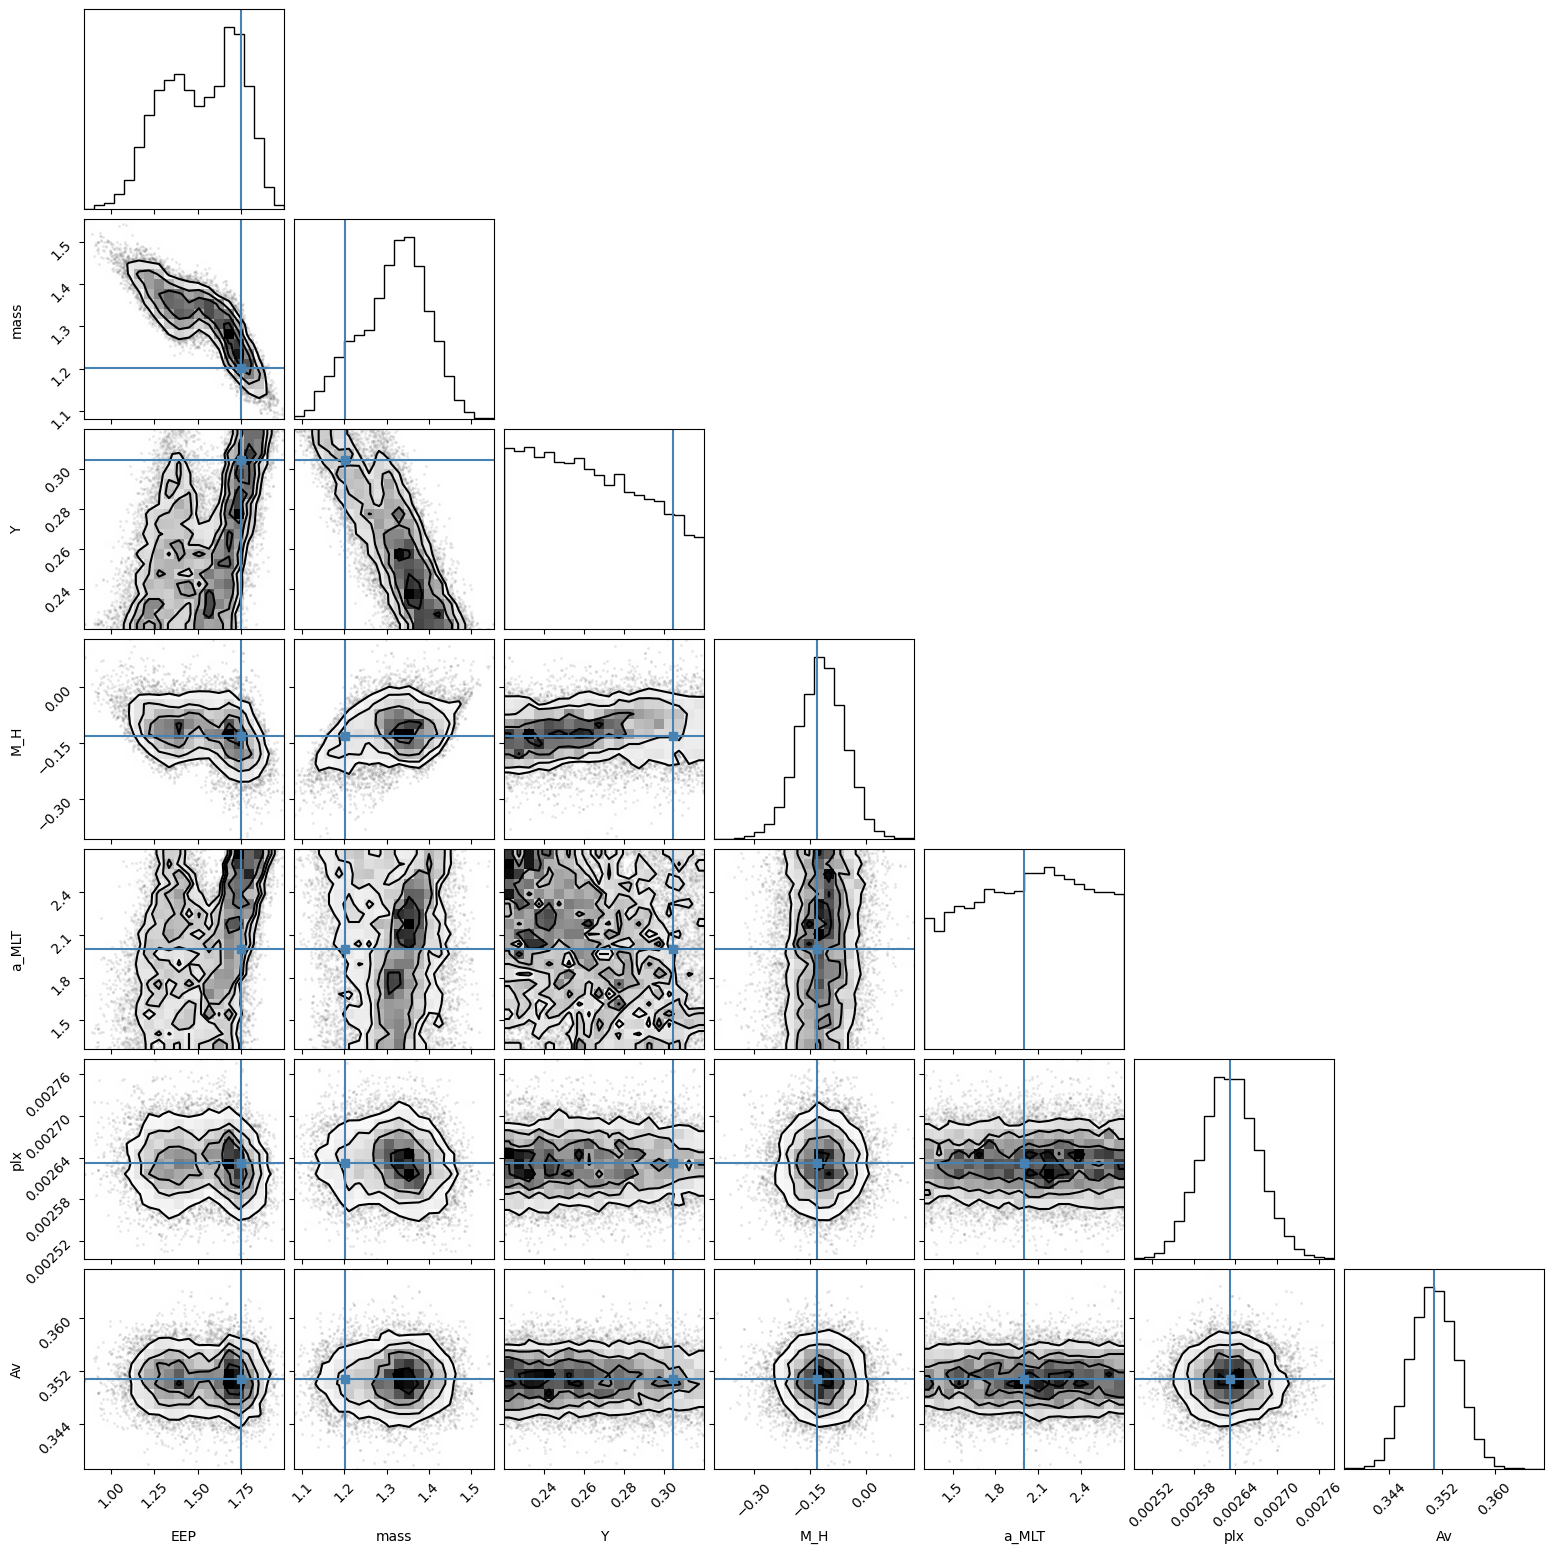

In [36]:
var_names = [
    "EEP", 
    "mass", 
    "Y", 
    "M_H", 
    "a_MLT", 
    "plx",
    "Av",
]

fig = corner(
    data, 
    var_names=var_names, 
    divergences=True,
    show_titles=True,
    truths={k: truths[k][i] for k in var_names}
#     truths=values
)

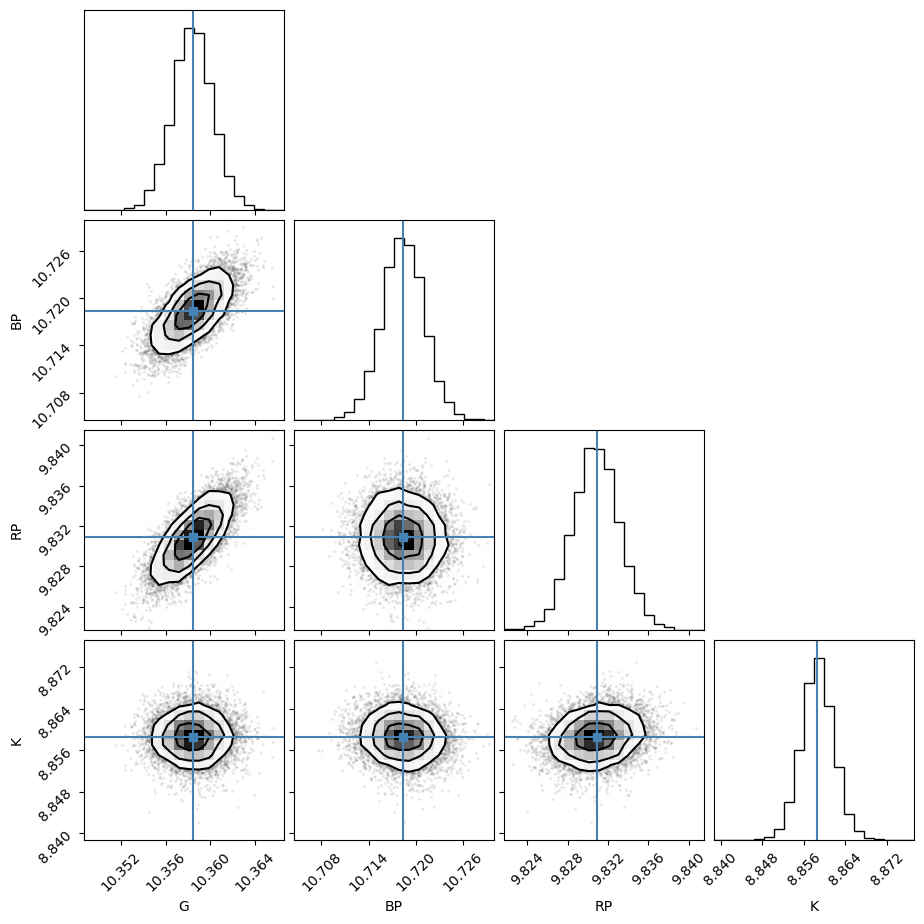

In [263]:
var_names = model.bands

fig = corner(
    data, 
    var_names=var_names, 
    divergences=True,
    truths={k: truths[k][i] for k in var_names}
)

In [19]:
from numpyro.contrib.nested_sampling import UniformReparam
from numpyro.infer.util import log_density

ImportError: To use this module, please install `jaxns` package. It can be installed with `pip install jaxns` with python>=3.8

In [129]:
rng, key = random.split(rng)
# reparam the model so that latent sites have Uniform(0, 1) priors
trace = handlers.trace(handlers.seed(model, key)).get_trace(const, obs=obs)
param_names = [
    site["name"]
    for site in trace.values()
    if site["type"] == "sample"
    and not site["is_observed"]
    and site["infer"].get("enumerate", "") != "parallel"
]
deterministics = [
    site["name"]
    for site in trace.values()
    if site["type"] == "deterministic"
]
reparam_model = handlers.reparam(
    model, config={k: UniformReparam() for k in param_names}
)

In [130]:
import dynesty
import jax
import dynesty.plotting as dyplot
from dynesty import NestedSampler
from dynesty.utils import resample_equal

In [24]:
jax.tree_unflatten(treedef, x)

/tmp/ipykernel_113078/1131691633.py:1: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  jax.tree_flatten(param_names)


(['x', 'ln_mass', 'Y', 'M_H', 'a_MLT', 'plx', 'Av'],
 PyTreeDef([*, *, *, *, *, *, *]))

In [131]:
base_names = [f"{name}_base" for name in param_names]

@jax.jit
def prior_transform(u):
    return u

@jax.jit
def log_likelihood(x):
    params = dict(zip(base_names, x))
    return log_density(reparam_model, (const, obs), {}, params)[0]

In [132]:
ndim = len(param_names)
ns = NestedSampler(log_likelihood, prior_transform, ndim, nlive=800, sample="rwalk")

In [133]:
ns.run_nested()

10305it [00:51, 201.11it/s, +800 | bound: 62 | nc: 1 | ncall: 229888 | eff(%):  4.847 | loglstar:   -inf < 19.445 <    inf | logz:  6.903 +/-  0.124 | dlogz:  0.001 >  0.809]


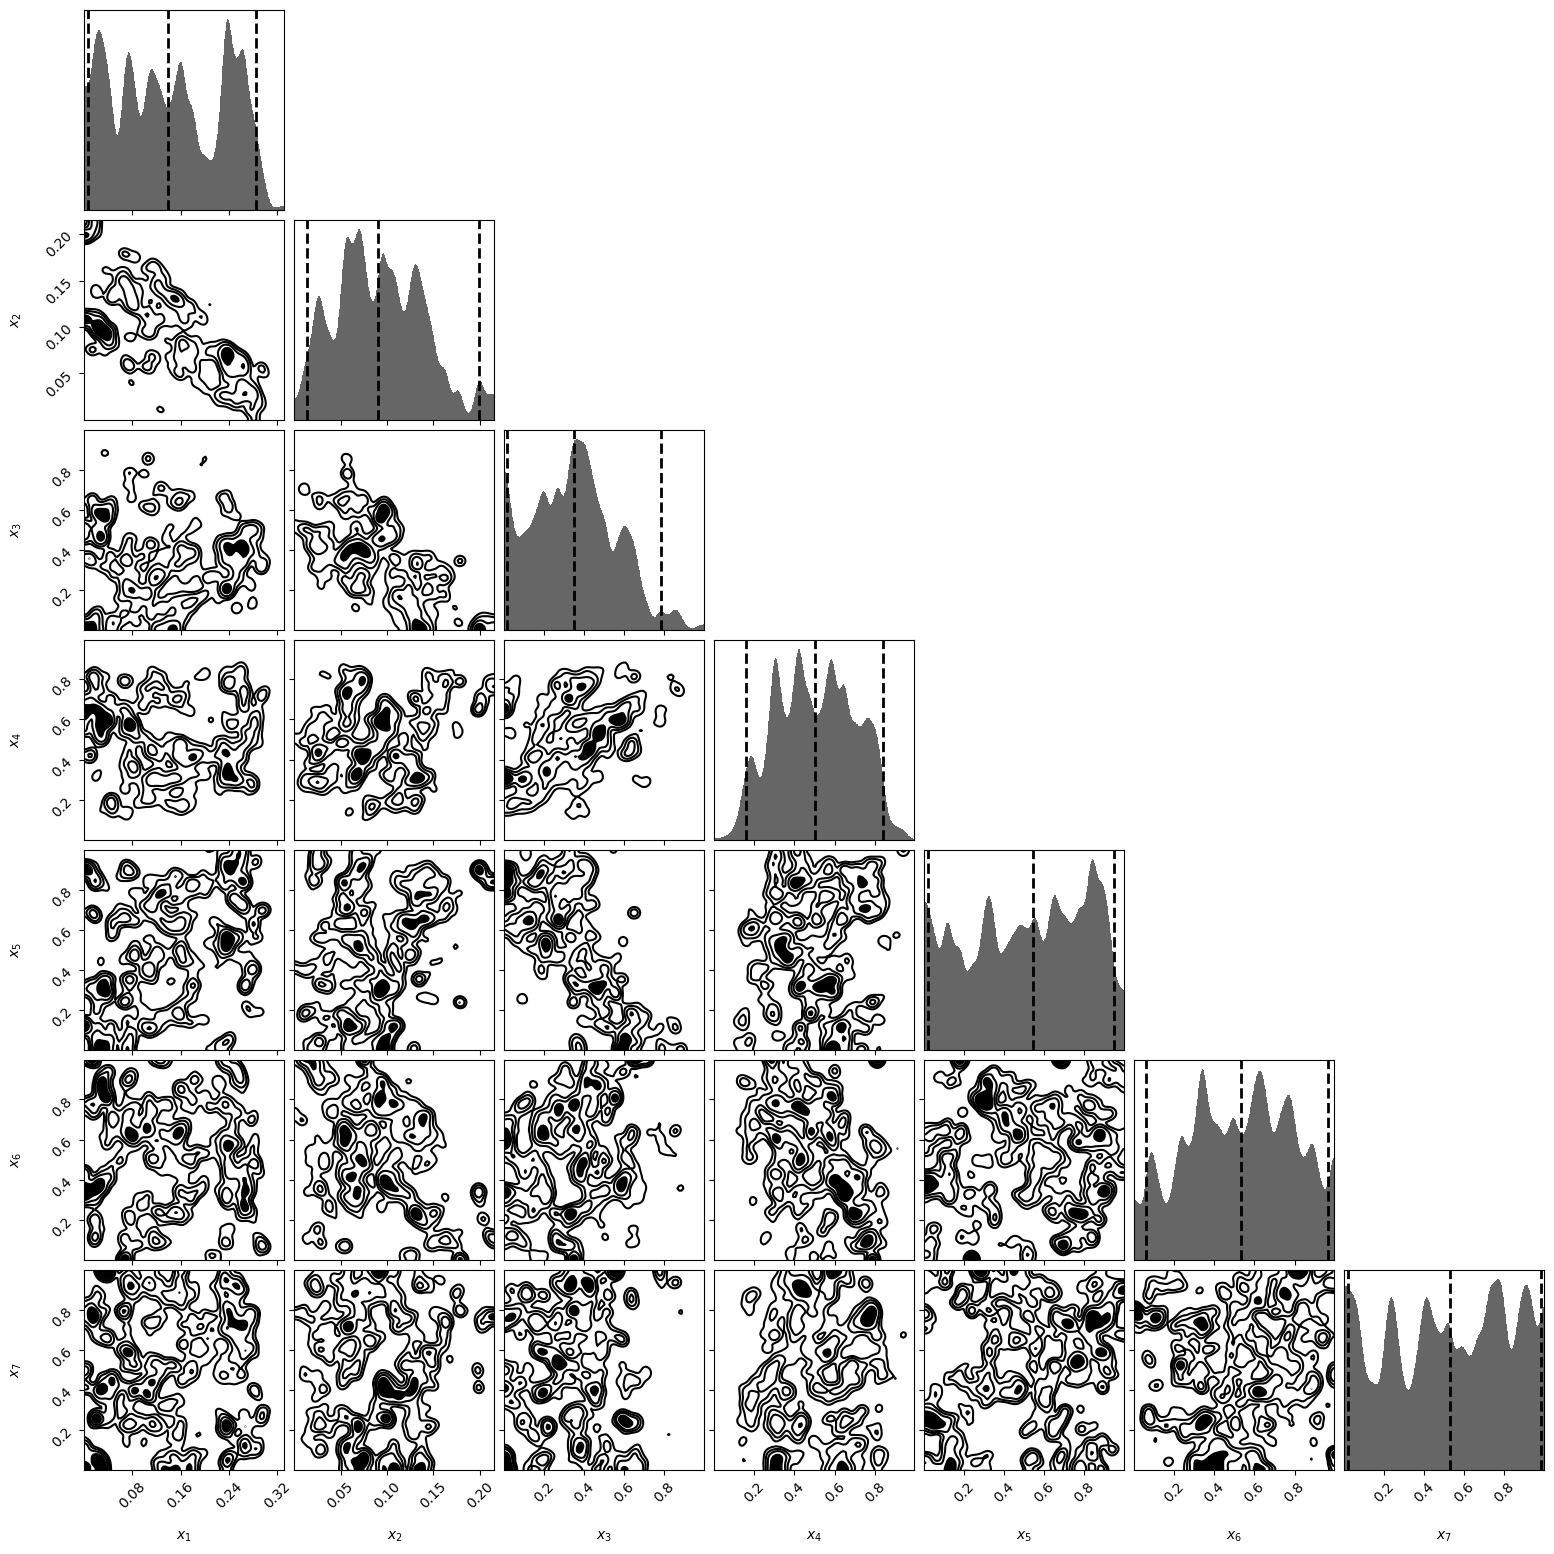

In [134]:
dyplot.cornerplot(ns.results);

In [135]:
samples = ns.results.samples_equal()
samples = dict(zip(base_names, samples.T))

In [145]:
rng, key = random.split(rng)
predict = Predictive(reparam_model, samples)
posterior = predict(key, const)
mask = posterior["age"] < 14e9
posterior = {key: value[mask] for key, value in posterior.items()}

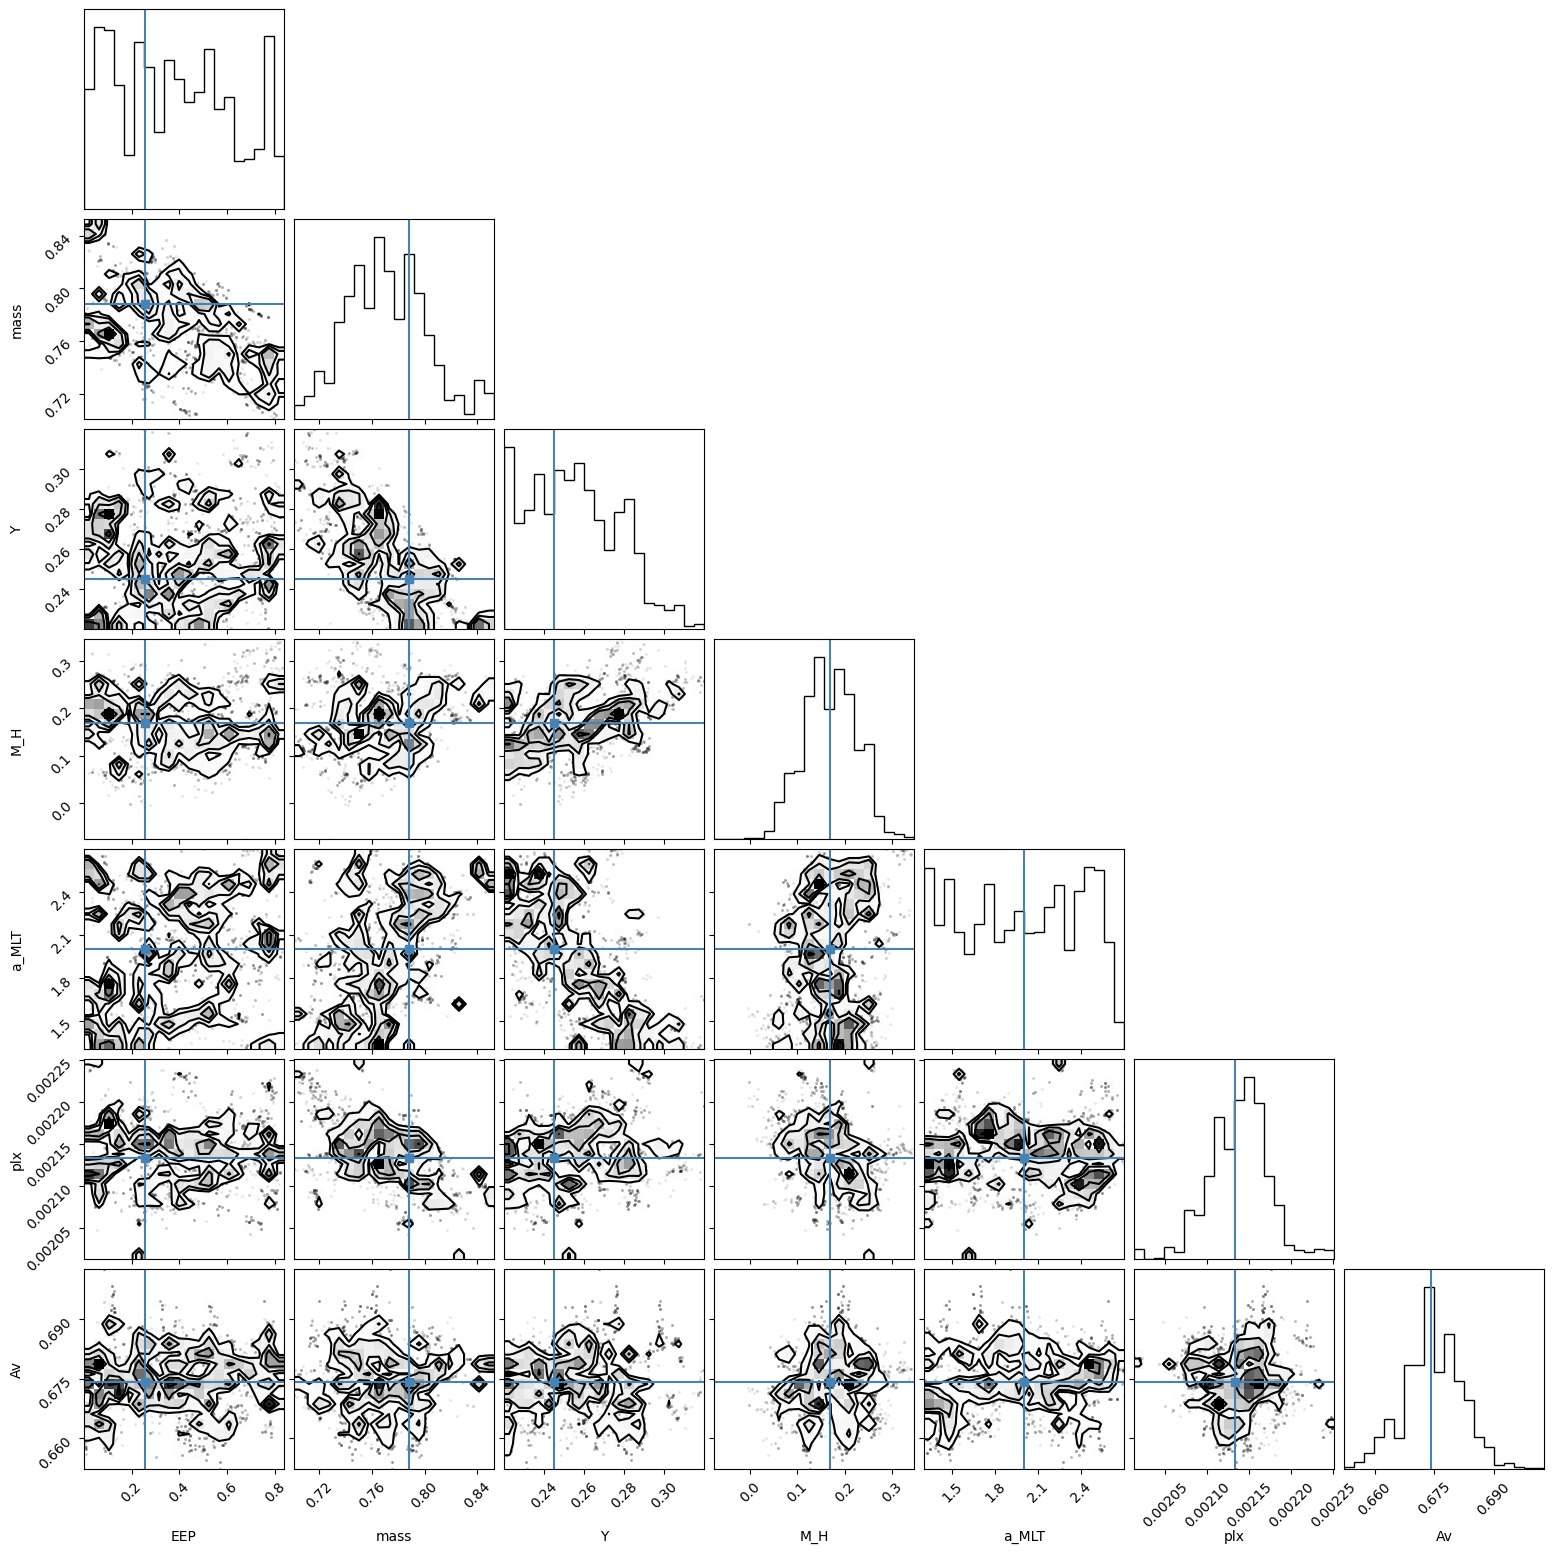

In [146]:
var_names=["EEP", "mass", "Y", "M_H", "a_MLT", "plx", "Av"]

fig = corner(
    posterior, 
    var_names=var_names, 
    truths={k: truths[k][i] for k in var_names}
)

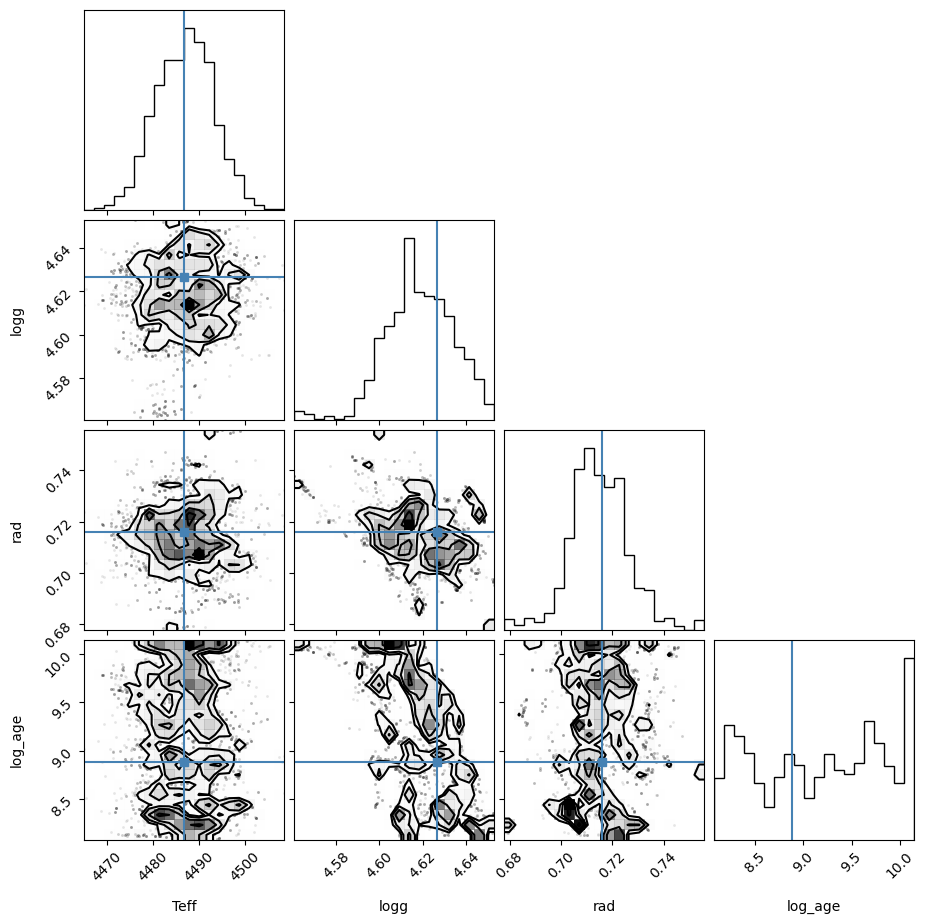

In [149]:
var_names = ["Teff", "logg", "rad", "log_age"]

fig = corner(
    posterior, 
    var_names=var_names, 
    truths={k: truths[k][i] for k in var_names}
)

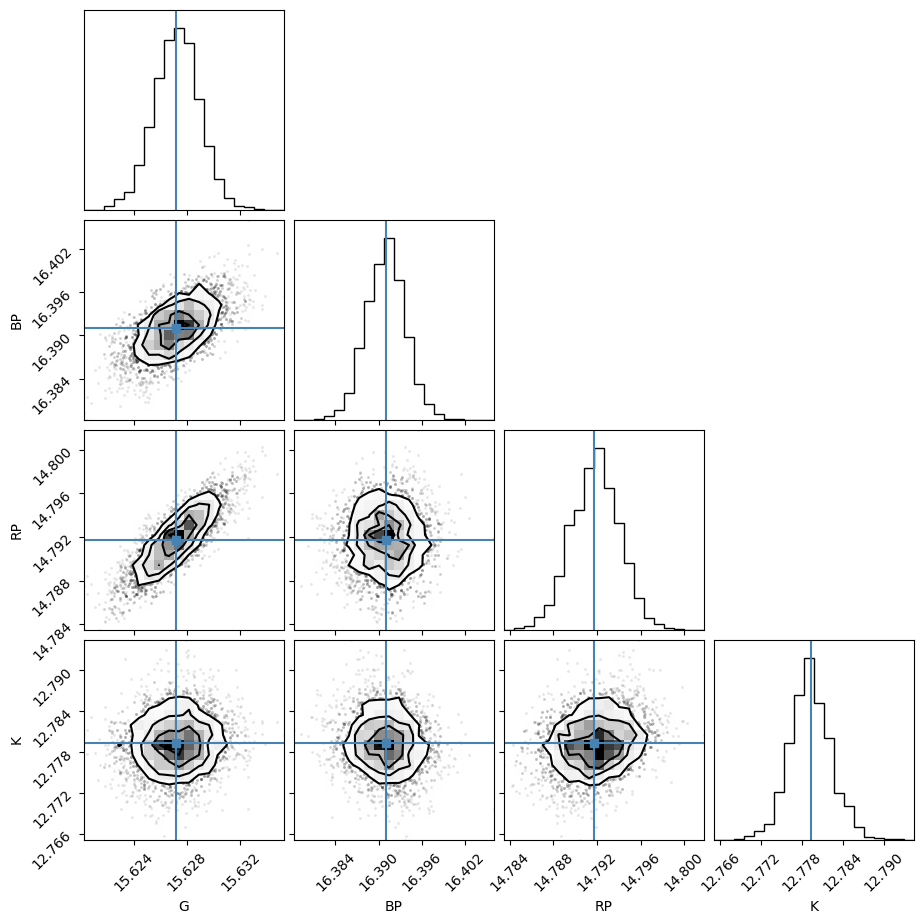

In [148]:
var_names = model.bands

fig = corner(
    posterior, 
    var_names=var_names, 
    truths={k: truths[k][i] for k in var_names}
)

In [150]:
from pytensor import tensor as pt

WARNING[2023-09-29 14:36:05,694]: Using NumPy C-API based implementation for BLAS functions.
